In [1]:
import time
import igraph as ig
import networkx as nx
import graph_tool.all as gt
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
G = nx.karate_club_graph()
edges = list(G.edges())  # add diagonal
# NetworkX graph
G_nx = nx.Graph()
G_nx.add_edges_from(edges)
# igraph graph
G_ig = ig.Graph(edges=edges)

G_gt = gt.Graph()
G_gt.add_edge_list(edges)

#partitioning
part_ig = [0] + [1] * 33
part_nx = [set([0]), set(range(1, 34))]

communities = [0] + [1] * (G_gt.num_vertices() - 1)
vprop = G_gt.new_vertex_property("int")

# Assign each vertex its community index
for v, c in zip(G_gt.vertices(), communities):
    vprop[v] = c

In [4]:
# igraph modularity benchmark
start = time.time()
mod = G_ig.modularity(part_ig, directed=False)
end = time.time()

# print with maximum precision
print("modularity",f"{mod:.16f}")   # 16 decimal places (double precision safe)
print(end - start)

modularity -0.0210387902695594
4.482269287109375e-05


In [5]:
# Benchmark NetworkX modularity
start = time.time()
mod_nx = nx.community.modularity(G_nx, part_nx)
end = time.time()

print("NetworkX modularity:", mod_nx)
print("Time:", end - start)

NetworkX modularity: -0.02103879026955959
Time: 0.0003209114074707031


In [6]:
# Benchmark graph-tool modularity
start = time.time()
mod_gt = gt.modularity(G_gt, vprop)
end = time.time()

print("NetworkX modularity:", mod_gt)
print("Time:", end - start)

NetworkX modularity: -0.02103879026955953
Time: 0.00035190582275390625


In [ ]:
def benchmark_modularity(sizes, p=0.05):
    results = []

    for n in sizes:
        # Generate a random graph
        G_nx = nx.erdos_renyi_graph(n, p)
        edges = list(G_nx.edges())

        # Partition: first node in one group, all others in another
        part_list = [0] + [1]*(n-1)
        part_set = [set([0]), set(range(1, n))]

        # igraph
        G_ig = ig.Graph(edges=edges)
        start = time.time()
        mod_ig = G_ig.modularity(part_list, directed=False)
        t_ig = time.time() - start

        # NetworkX
        start = time.time()
        mod_nx = nx.community.modularity(G_nx, part_set)
        t_nx = time.time() - start

        # graph-tool
        G_gt = gt.Graph(directed=False)
        G_gt.add_edge_list(edges)
        
        vprop = G_gt.new_vertex_property("int")
        for v, c in zip(G_gt.vertices(), part_list):
            vprop[v] = c

        start = time.time()
        mod_gt = gt.modularity(G_gt, vprop)
        t_gt = time.time() - start

        # Print modularity for verification
        print(f"Nodes: {n}")
        print(f"igraph modularity:     {mod_ig:.16f}, Time: {t_ig:.6f}s")
        print(f"NetworkX modularity:   {mod_nx:.16f}, Time: {t_nx:.6f}s")
        print(f"graph-tool modularity: {mod_gt:.16f}, Time: {t_gt:.6f}s")
        print("-"*50)

        # Store results
        results.append({
            "nodes": n,
            "igraph_modularity": mod_ig,
            "igraph_time": t_ig,
            "networkx_modularity": mod_nx,
            "networkx_time": t_nx,
            "graphtool_modularity": mod_gt,
            "graphtool_time": t_gt
        })

    df = pd.DataFrame(results)
    return df

# Example sizes
sizes = [1000, 2000, 5000, 10000]
df_results = benchmark_modularity(sizes)

Nodes: 1000
igraph modularity:     -0.0000017431319936, Time: 0.000101s
NetworkX modularity:   -0.0000017431319938, Time: 0.006635s
graph-tool modularity: -0.0000017431319936, Time: 0.000440s
--------------------------------------------------
Nodes: 2000
igraph modularity:     -0.0000006735137356, Time: 0.000427s
NetworkX modularity:   -0.0000006735137354, Time: 0.025128s
graph-tool modularity: -0.0000006735137353, Time: 0.001015s
--------------------------------------------------
Nodes: 5000
igraph modularity:     -0.0000000776499544, Time: 0.002205s
NetworkX modularity:   -0.0000000776499544, Time: 0.158037s
graph-tool modularity: -0.0000000776499544, Time: 0.004807s
--------------------------------------------------
Nodes: 10000
igraph modularity:     -0.0000000209727615, Time: 0.008748s
NetworkX modularity:   -0.0000000209727615, Time: 0.634244s
graph-tool modularity: -0.0000000209727616, Time: 0.018972s
--------------------------------------------------


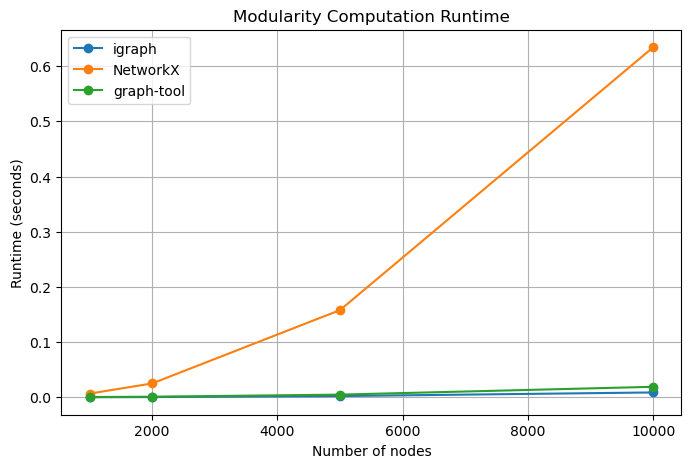

In [8]:
# Plot runtimes
plt.figure(figsize=(8,5))
plt.plot(df_results['nodes'], df_results['igraph_time'], marker='o', label='igraph')
plt.plot(df_results['nodes'], df_results['networkx_time'], marker='o', label='NetworkX')
plt.plot(df_results['nodes'], df_results['graphtool_time'], marker='o', label='graph-tool')
plt.xlabel("Number of nodes")
plt.ylabel("Runtime (seconds)")
plt.title("Modularity Computation Runtime")
plt.legend()
plt.grid(True)
plt.show()